In [1]:
#нужно подставить модели; вроде как по дефолту у yolo 640x640? но не совсем уверен про корректность нормировки координат
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from ultralytics.utils.ops import scale_image
import math

model1 = YOLO("weights/best_detection.pt")
model2 = YOLO("weights/best_segmentation.pt")
img = cv2.imread("images/night_pedestrian_3.png")

results_pesh = model1(img)
results_road = model2(img)
threshold = 10 

class_names = results_pesh[0].names


0: 416x640 2 persons, 74.0ms
Speed: 3.4ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 Roads, 89.4ms
Speed: 2.0ms preprocess, 89.4ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)


In [2]:
def get_resized_mask(yolo_segment_res):
    
    yolo_segment_res = yolo_segment_res[0]

    if yolo_segment_res.masks is None:
        return np.zeros([*yolo_segment_res.orig_shape, 1])

    result_mask = yolo_segment_res.masks.data.numpy()
    result_mask = np.moveaxis(result_mask, 0, -1)
    result_mask = scale_image(result_mask, yolo_segment_res.orig_shape)
    
    return result_mask

In [3]:
def draw_mask(image, mask_generated) :
  
  masked_image = image.copy()

  masked_image = np.where(mask_generated.astype(int),
                          np.array([255,0,0], dtype='uint8'),
                          masked_image)

  masked_image = masked_image.astype(np.uint8)

  return cv2.addWeighted(image, 0.7, masked_image, 0.3, 0)

In [4]:
def plot_detect_segment(image, bboxs_xyxy=[], segment_mask=None):

    res_image = image.copy()
    
    for bbox in bboxs_xyxy:
        cv2.rectangle(res_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        
    if segment_mask is None:
        return res_image
    
    return draw_mask(res_image, segment_mask)

In [5]:
def if_person_on_road(bbox_xyxy, segment_mask, segment_polygons, threshold=10):

    x_mean = (bbox_xyxy[2] + bbox_xyxy[0]) // 2
    y_bot = bbox_xyxy[3] 

    if segment_mask[y_bot][x_mean] == 1:
        return True

    min_dist = float("+Inf")

    for x, y in segment_polygons:
        dist = math.sqrt((x_mean - x) ** 2 + (y_bot - y) ** 2)
        min_dist = min(min_dist, dist)
    
    return min_dist < threshold

In [22]:
def merge_masks(mask):

    result_mask = np.any(mask, axis=2)
    return np.expand_dims(result_mask, axis=2)

In [23]:
def merge_polygons(segment_polygons):
    
    return np.concatenate(segment_polygons)

In [24]:
boxes = results_pesh[0].boxes.xyxy.numpy().astype("int16")

resized_mask = get_resized_mask(results_road)
resized_mask = merge_masks(resized_mask)

if not results_road[0].masks:
    segment_areas = []
else:
    segment_areas = results_road[0].masks.xy
    segment_areas = merge_polygons(segment_areas)

result_bboxes = []

for box_ind in range(len(boxes)):
    if not if_person_on_road(boxes[box_ind], resized_mask, segment_areas):
        continue
    result_bboxes.append(boxes[box_ind])

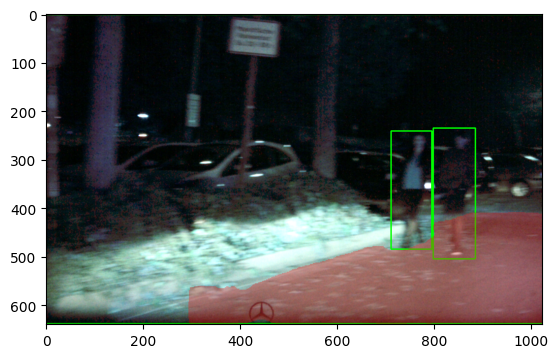

In [25]:
plt.imshow(plot_detect_segment(img, result_bboxes, resized_mask))